# Проект 9. Оценка стоимости автомобилей.


**Описание проекта:**

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля. 

**Цель проекта:**

Создать модель, которая будет определять рыночную стоимость автомобиля, на основе данных о технических характеристиках, комплектации и ценах других автомобилей и с учитом критериев заказчика:
- качество предсказания;
- время обучения модели;
- время предсказания модели.

**Задачи проекта:**

1. Построить и обучить несколько моделей, одна из которых основана на градиентном бустинге
2. Оценить и сравнить качество предсказания этих моделей, время обучения и время предсказания.
3. Выбрать лучшую модель, исходя из требований заказчика

**План работы:**

1. Загрузка данных, изучение первичной информации.
2. Предварительная обработка данных:
   - 2.1. Проверка на явные дубликаты.
   - 2.2. Проверка на скрытые дубликаты.
   - 2.3. Поиск пропущенных значений.
   - 2.4. Изменение типов данных.
3. Исследовательский анализ данных:
   - 3.1. Изучение количественных столбцов.
   - 3.2. Заполнение нулей и удаление аномальных значений.
   - 3.3. Построение диаграмм к столбцам с категориальными признаками.
   - 3.4. Корреляционный анализ данных.
4. Подготовка данных для МО:
    - 4.1. Добавление нового столбца
    - 4.1. Удаление неинформативных столбцов.
    - 4.2. Разделение выборки.
    - 4.3. Подготовка данных.
5. Подбор модели для машинного обучения.
     - 5.1. Простые модели.
     - 5.2. Модель LightGBM.
6. Вывод
    



## 1. Загрузка данных, изучение первичной информации.

In [1]:
! pip install phik -q
! pip install -U scikit-learn -q
! pip install lightgbm -q

In [2]:
# Загрузим необходимые для работы библиотеки

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import phik
import lightgbm
import time
import math

from phik.report import plot_correlation_matrix

from sklearn.linear_model import  LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, make_scorer

from numpy.random import RandomState

from lightgbm import LGBMRegressor

In [3]:
# Откроем файл autos.csv

try:
    autos = pd.read_csv('/datasets/autos.csv', parse_dates = ['DateCrawled', 'DateCreated', 'LastSeen'])
except:
    autos = pd.read_csv('autos.csv', parse_dates = ['DateCrawled', 'DateCreated', 'LastSeen'])
    
autos.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


In [4]:
# Выведем общую информацию о датасете:

autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

В предоставленной таблице 16 столбцов и 354368 строк, есть пропущенные значения.

Описания столбцов:

- DateCrawled — дата скачивания анкеты из базы
- Price — цена (евро) - целевой признак.
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя


Мы загрузили данные и провели их предварительный осмотр. Приступаем к этапу предобработки.

## 2. Предобработка данных.

### 2.1. Проверка на явные дубликаты.

In [5]:
# Проверим данные на явные дубликаты

autos.duplicated().sum()

4

В таблице 4 строки с дубликатами. Удалим их.


In [6]:
# Проверим размер таблицы

autos.shape

(354369, 16)

In [7]:
# удалим дубликаты

autos = autos.drop_duplicates()
autos.shape

(354365, 16)

### 2.2. Проверка на скрытые дубликаты.

Проверим столбцы с текстовыми данными на скрытые дубликаты

In [8]:
cat_columns = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']

In [9]:
for column in cat_columns:
    print (column, autos[column].sort_values().unique())

VehicleType ['bus' 'convertible' 'coupe' 'other' 'sedan' 'small' 'suv' 'wagon' nan]
Gearbox ['auto' 'manual' nan]
Model ['100' '145' '147' '156' '159' '1_reihe' '1er' '200' '2_reihe' '300c'
 '3_reihe' '3er' '4_reihe' '500' '5_reihe' '5er' '601' '6_reihe' '6er'
 '7er' '80' '850' '90' '900' '9000' '911' 'a1' 'a2' 'a3' 'a4' 'a5' 'a6'
 'a8' 'a_klasse' 'accord' 'agila' 'alhambra' 'almera' 'altea' 'amarok'
 'antara' 'arosa' 'astra' 'auris' 'avensis' 'aveo' 'aygo' 'b_klasse'
 'b_max' 'beetle' 'berlingo' 'bora' 'boxster' 'bravo' 'c1' 'c2' 'c3' 'c4'
 'c5' 'c_klasse' 'c_max' 'c_reihe' 'caddy' 'calibra' 'captiva' 'carisma'
 'carnival' 'cayenne' 'cc' 'ceed' 'charade' 'cherokee' 'citigo' 'civic'
 'cl' 'clio' 'clk' 'clubman' 'colt' 'combo' 'cooper' 'cordoba' 'corolla'
 'corsa' 'cr_reihe' 'croma' 'crossfire' 'cuore' 'cx_reihe' 'defender'
 'delta' 'discovery' 'doblo' 'ducato' 'duster' 'e_klasse' 'elefantino'
 'eos' 'escort' 'espace' 'exeo' 'fabia' 'fiesta' 'focus' 'forester'
 'forfour' 'fortwo' 'fox' 

Скрытые дубликаты есть в столбцах Model и FuelType, исправим их.

In [10]:
len(autos['Model'].unique())

251

In [11]:
autos['Model'] = autos['Model'].replace('rangerover','range_rover')
len(autos['Model'].unique())

250

In [12]:
len(autos['FuelType'].unique())

8

In [13]:
autos['FuelType'] = autos['FuelType'].replace('gasoline', 'petrol')

In [14]:
len(autos['FuelType'].unique())

7

### 2.3. Поиск пропущенных значений.

Проверим пропуски в таблице.

In [15]:
autos.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

В таблице есть пропуски в 5 столбцах: VehicleType, Gearbox, Model, FuelType, Repaired. 

Заполним пропуски в столбцах FuelType, Model и VehicleType значением 'other'.

In [16]:
autos['VehicleType'] = autos['VehicleType'].fillna('other')

In [17]:
autos['Model'] = autos['Model'].fillna('other')

In [18]:
autos['FuelType'] = autos['FuelType'].fillna('other')

Пропуск в столбце Repaired заменим значением 'no'. Появление пропусков в этом столбце может быть связано с тем, что пользователь не заполнял его, если машина не была в аварии, но возможен и вариант умолчания именно факта аварии. Так как мы не имеем достаточных оснований для подтверждения второго варианта, пропуски лучше заполнить значением 'no'. 

In [19]:
autos['Repaired'] = autos['Repaired'].fillna('no')

Пропуск в столбце Gearbox заменим в пайплайн.

In [20]:
autos.isna().sum()

DateCrawled              0
Price                    0
VehicleType              0
RegistrationYear         0
Gearbox              19833
Power                    0
Model                    0
Kilometer                0
RegistrationMonth        0
FuelType                 0
Brand                    0
Repaired                 0
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Пропуски в данных заполнены. После заполнения пропусков еще раз проверим явные дубликаты и удалим их, если они есть.

In [21]:
autos.duplicated().sum()

1

In [22]:
autos = autos.drop_duplicates()
autos.shape

(354364, 16)

### 2.4. Изменение типов данных.

Еще раз вызовем общую информацию о таблице и проверим типы данных столбцов.

In [23]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 354364 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354364 non-null  datetime64[ns]
 1   Price              354364 non-null  int64         
 2   VehicleType        354364 non-null  object        
 3   RegistrationYear   354364 non-null  int64         
 4   Gearbox            334531 non-null  object        
 5   Power              354364 non-null  int64         
 6   Model              354364 non-null  object        
 7   Kilometer          354364 non-null  int64         
 8   RegistrationMonth  354364 non-null  int64         
 9   FuelType           354364 non-null  object        
 10  Brand              354364 non-null  object        
 11  Repaired           354364 non-null  object        
 12  DateCreated        354364 non-null  datetime64[ns]
 13  NumberOfPictures   354364 non-null  int64        

Типы данных столбцов соответсвуют представленной в них информации, дополнительная обработка не требуется.

В ходе предварительной обработки данных предоставленный датасет был проверен на наличие дубликатов, строки с дубликатами были удалены. Проведена проверка на наличие скрытых дубликатов в текстовых данных и выполнена замена таких значений. 
Данные были проверены на наличие пропусков: в столбцах FuelType, Model и VehicleType пропуски были заменены на значение 'other'. 
Пропуск в столбце Repaired заменим значением 'no'. Пропуски в столбце Gearbox мы заменим в пайплайн.

Предварительная обработка данных проведена. Приступаем к исследовательскому анализу данных.

## 3. Исследовательский анализ данных.


### 3.1. Изучение количественных столбцов.

In [24]:
# Вызовем описательные характеристики таблицы

autos.describe().T

,count,mean,min,25%,50%,75%,max,std
DateCrawled,354364,2016-03-21 12:58:06.006688256,2016-03-05 14:06:22,2016-03-13 11:52:32.750000128,2016-03-21 17:50:55,2016-03-29 14:37:20,2016-04-07 14:36:58,NaN
Price,354364.0,4416.655608,0.0,1050.0,2700.0,6400.0,20000.0,4514.15969
RegistrationYear,354364.0,2004.234471,1000.0,1999.0,2003.0,2008.0,9999.0,90.228593
Power,354364.0,110.093723,0.0,69.0,105.0,143.0,20000.0,189.85159
Kilometer,354364.0,128211.373051,5000.0,125000.0,150000.0,150000.0,150000.0,37905.136957
RegistrationMonth,354364.0,5.714641,0.0,3.0,6.0,9.0,12.0,3.726433
DateCreated,354364,2016-03-20 19:12:03.120858368,2014-03-10 00:00:00,2016-03-13 00:00:00,2016-03-21 00:00:00,2016-03-29 00:00:00,2016-04-07 00:00:00,NaN
NumberOfPictures,354364.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PostalCode,354364.0,50508.461698,1067.0,30165.0,49409.5,71083.0,99998.0,25783.124276
LastSeen,354364,2016-03-29 23:51:05.174749952,2016-03-05 14:15:08,2016-03-23 02:50:03,2016-04-03 15:15:51.500000,2016-04-06 10:15:19,2016-04-07 14:58:51,NaN


В нашей таблице есть пустой столбец NumberOfPictures - по каким-то причинам данные в этом столбце оказались не заполнены и выгрузились в виде 0. В идеале необходимо было бы уточнить причину пропажи данных и постараться их получить, так как для оценки стоимости авто в приложении наличие фото автомобиля могло бы оказать влияние на его цену. В нашем случае столбец нужно будет удалить.

Так же стоит обратить внимание на столбец с ценой - это целевой признак - значения с 0 необходимо будет удалить, так как они являются выбросными и окажут негативное влияние на процесс обучения модели.

В столбце RegistrationYear есть странные максимальные и минимальные значения, являющиеся аномальными.
В столбце Power есть незаполненные нулевые значения и достаточно высокие максимальные, которые скорее всего будут являться аномалией для наших данных.

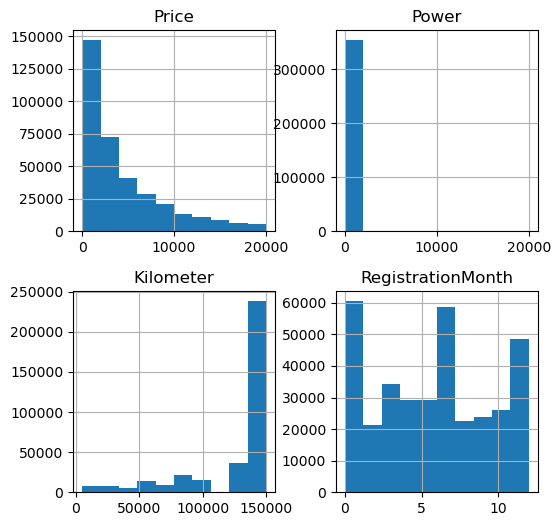

In [25]:
# Построим гистограммы распределения количественных признаков 
num_cols = ['Price', 'Power', 'Kilometer', 'RegistrationMonth']

autos[num_cols].hist(figsize=(6,6));

Значения столбца Price сильно смещены влево из-за большого количества нулевых значений, в толбце Power присутствует выбросное значение на отметке 20000, остальные значения сосредоточены в пределах от 0 до 2000. В столбце Kilometer основная масса значений смещена вправо к отметке 150 000. В столбце RegistrationMonth значения распределены достаточно равномерно с пиками в отметках 0, 6, 12.


Построим box_plot для количественных столбцов.

C:\Users\Роман Полицинский\AppData\Local\Temp\ipykernel_8948\3788511080.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(8,1,i)


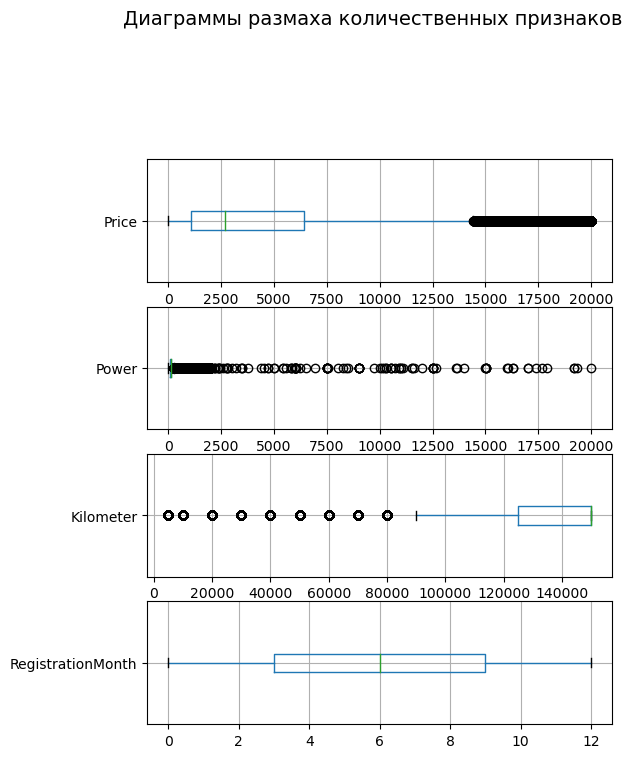

In [26]:
i=1
fig, ax = plt.subplots(figsize = (6,15))
plt.suptitle(('Диаграммы размаха количественных признаков'), color = 'black', fontsize = 14)
for column in num_cols:
    plt.subplot(8,1,i)
    ax = autos[[column]].boxplot(vert=False)
    i+=1;

По boxplot видно, что основные значения столбца Price распределились в пределах от 0 до 145000 примерно. Boxplot столбца Power очень сильно смещен влево из-за выбросных значений в отметках больше 2000. У столбца Kilometer boxplot смещен вправо, основная масса значений сосредоточена в пределах от 90 000 до 150000, при этом медиана совпадает с максимальным значением.


Таким образом, в количественных столбцах есть проблемы с данными в столбце Price: нулевые значения целевого столбца разумнее всего будет заполнить медианой, так как среднеарифметическое будет сильно смещено вправо из-за наличия единичных высоких значений цены.

В столбце Power необходимо будет избавиться от редких высоких значений.

### 3.2. Заполнение нулей и удаление аномальных значений.

In [27]:
# Подсчитаем количество нулевых значений в столбце Price
nul_price = round(autos[autos['Price']==0].shape[0]/autos.shape[0]*100,2)
nul_price

3.04

В нашей таблице около 3% строк имеют нулевое значение целевого признака, заполним эти данные медианой.

In [28]:
median=autos['Price'].median()

In [29]:
autos['Price'] = autos['Price'].replace(0, median)
nul_price = autos[autos['Price']==0]['Price'].count() 
nul_price

0

Теперь обработаем аномальные значения в столбце Power. Посмотрим на интервал в 0,9976 квантилей.

In [30]:
autos[['Power']].quantile([0.0012, 0.01, .5, .99, .9988]).style.format("{:,.2f}")

,Power
0.001200,0.00
0.010000,0.00
0.500000,105.00
0.990000,300.00
0.998800,520.00


In [31]:
autos.Power.value_counts().to_frame()

,count
Power,
0,40225
75,24023
60,15897
150,14590
101,13298
...,...
610,1
6006,1
5815,1


В столбце Power так же много нулевых значений, которые лучше заполнить медианой, а редкие высокие значения (больше 0,9988 квантиля) лучше удалить.

In [32]:
autos.shape

(354364, 16)

In [33]:
autos = autos.query('Power <520')
autos.shape

(353937, 16)

In [34]:
median_power = autos['Power'].median()

In [35]:
autos['Power'] = autos['Power'].replace(0, median_power)

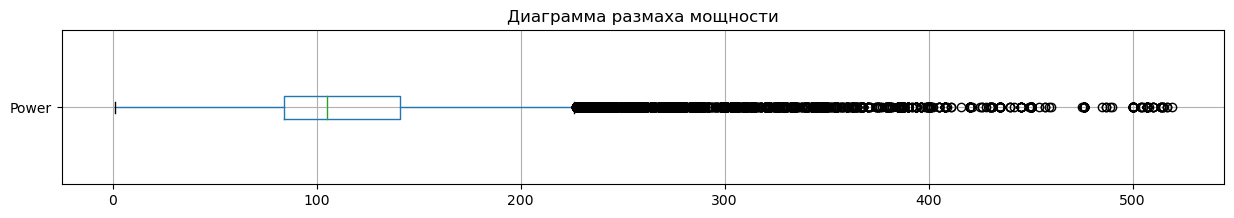

In [36]:
fig, ax = plt.subplots(figsize = (15,2))
ax = autos[["Power"]].boxplot(vert=False, ax=ax)
ax.set_title('Диаграмма размаха мощности');

Мы избавились от аномально больших значений с толбце Power и заполнили пропуски медианным значением.

Проверим теперь аномальные значения в столбце RegistrationYear - максимальное и минимальное значение этого столбца - 9999 и 1000  не соответствуют логике. Посмотрим, сколько всего у нас таких значений.

In [37]:
autos.RegistrationYear.value_counts().to_frame()

,count
RegistrationYear,
2000,24462
1999,22699
2005,22089
2001,20099
2006,19879
...,...
2290,1
1001,1
9450,1


In [38]:
autos[['RegistrationYear']].quantile([0.0012, 0.01, .5, .99, .9988]).style.format("{:,.2f}")

,RegistrationYear
0.001200,"1,960.00"
0.010000,"1,980.00"
0.500000,"2,003.00"
0.990000,"2,018.00"
0.998800,"2,018.00"


Исходя из данных столбца DateCreated, мы знаем, что наши данные ограничены 2016 годом, поэтому машин с датой регистрации позже 2016 года в предоставленных данных быть не может. Нижнюю планку ограничим 0,0012 квантилем или 1960 годом. Проверим, сколько строк попадает под удаление.

In [39]:
unnormal_reg_year = autos.query('RegistrationYear >=2017 or RegistrationYear <1960')
unnormal_reg_year.shape

(14911, 16)

Под удаление попадает около 4% строк, но эти строки изначально могут нести недостоверную информацию и повлиять на обучение модели, поэтому их стоит удалить

In [40]:
autos = autos.query('RegistrationYear <2017 and RegistrationYear >1960')
autos.shape

(338838, 16)

Теперь удалим из нашей таблицы столбец NumberOfPictures поскольку он не несет никакой информации

In [41]:
autos = autos.drop('NumberOfPictures', axis = 1)
autos.shape

(338838, 15)

Мы обработали все категориальные столбцы и удалили аномальные значения. Переходим к столбцам с категориальными признаками.

### 3.3. Построение диаграмм к столбцам с категориальными признаками

В список категориальных столбцов для построения диаграмм не будем включать столбцы 'Model' и 'Brand' поскольку они имеют очень много уникальных значений, диаграммы по ним построим отдельно ниже.

In [42]:
cat_cols = ['VehicleType', 'Gearbox', 'FuelType', 'Repaired']

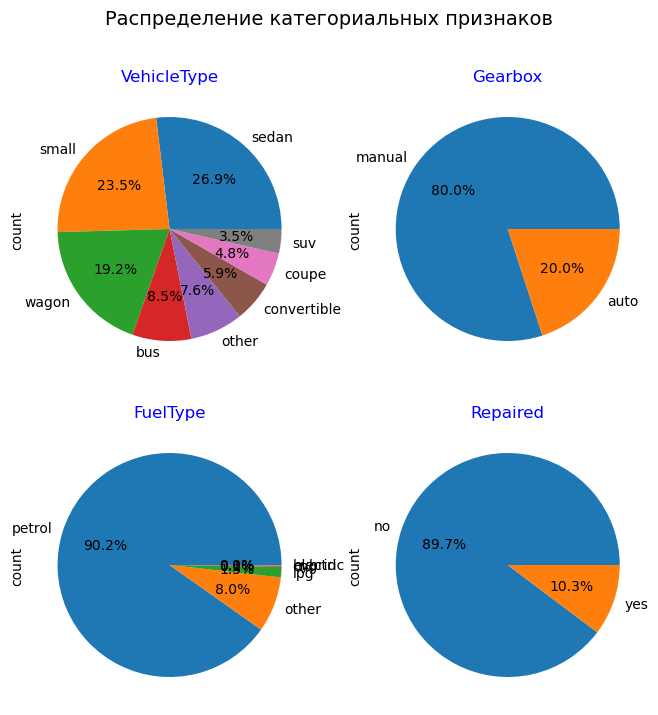

In [43]:
i=1
plt.suptitle(('Распределение категориальных признаков'), color = 'black', fontsize = 14)
for column in cat_cols:
    plt.subplot(2,2,i)
    autos[column].value_counts().plot(kind='pie', legend=False, autopct='%1.1f%%', figsize=(8,8))
    plt.title(column, color='blue')
    i+=1;

В столбце VehicleType преобладают типы sedan (28.9%), small (25.2%) и wagon (20.6%). В столбце GearBox преобладают машины с ручной коробкой передач. В столбце FuelType преобладают машины на бензиновом двигателе (67.3%), в столбце Repaired в основном представлены машины не попадавшие в аварии (87.3%).

Теперь построим диаграммы для столбцов Model и Brand: сначала выведем топ-10 самых популярных марок и моделей, более мелкие объединим  в категорию 'остальные'.

In [44]:
big_models = autos['Model'].value_counts().head(10)
big_models.to_frame()

,count
Model,
other,40966
golf,27587
3er,19206
polo,12435
corsa,11921
astra,10324
passat,9829
a4,9687
c_klasse,8106


In [45]:
autos_others = autos['Model'].apply(lambda x: x if x in big_models else 'остальные модели')

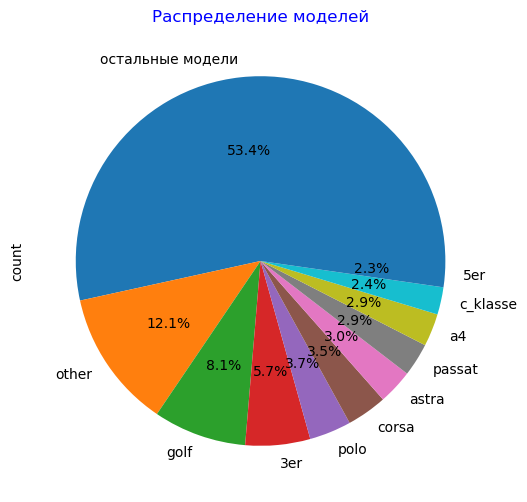

In [46]:
autos_others.value_counts().plot(kind='pie', legend=False, autopct='%1.1f%%', figsize=(6,6))
plt.title('Распределение моделей', color='blue');

58,8% на диаграмме суммарно занимают мелкие в количественном значении модели машин, из наиболее часто встречающихся - модели golf(8.2%), 3er (6,9%).

In [47]:
big_brand = autos['Brand'].value_counts().head(10)
big_brand.to_frame()

,count
Brand,
volkswagen,73058
opel,37896
bmw,35745
mercedes_benz,30934
audi,28436
ford,24107
renault,16898
peugeot,10612
fiat,9125


In [48]:
autos_others_brand = autos['Brand'].apply(lambda x: x if x in big_brand else 'остальные бренды')

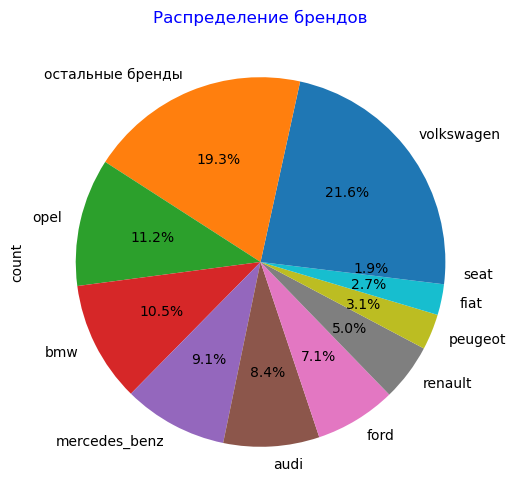

In [49]:
autos_others_brand.value_counts().plot(kind='pie', legend=False, autopct='%1.1f%%', figsize=(6,6))
plt.title('Распределение брендов', color='blue');

В столбце бренды лидирует volkswagen (21.7%), затем суммарная категория мелких брендов (19.3%), а так же opel (11.3%).

### 3.4. Корреляционный анализ данных.

Корреляционный анализ наших данных проведем с помощью библиотеки phik, поскольку нам необходимо установить связь как между количественными, так и между категориальными столбцами.

In [50]:
autos.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired', 'DateCreated', 'PostalCode', 'LastSeen'],
      dtype='object')

In [51]:
interval_cols=['Price', 'Power', 'Kilometer', 
               'RegistrationMonth', 'DateCrawled', 
               'RegistrationYear', 'DateCreated', 'LastSeen']
columns = ['Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired']
phik_overview = autos[columns].phik_matrix(interval_cols=interval_cols)
phik_overview

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
Price,1.000000,0.282757,0.644561,0.326887,0.488246,0.566025,0.306563,0.154102,0.128450,0.357517,0.277862
VehicleType,0.282757,1.000000,0.277606,0.288121,0.426645,0.904004,0.197208,0.207970,0.319729,0.623577,0.063869
RegistrationYear,0.644561,0.277606,1.000000,0.129018,0.269452,0.616803,0.379657,0.135559,0.112793,0.375255,0.148045
Gearbox,0.326887,0.288121,0.129018,1.000000,0.566702,0.629240,0.019622,0.046399,0.110673,0.522592,0.033374
Power,0.488246,0.426645,0.269452,0.566702,1.000000,0.749192,0.095126,0.102555,0.119378,0.538590,0.066399
Model,0.566025,0.904004,0.616803,0.629240,0.749192,1.000000,0.437620,0.172980,0.357731,0.997752,0.125758
Kilometer,0.306563,0.197208,0.379657,0.019622,0.095126,0.437620,1.000000,0.099644,0.142727,0.287348,0.086210
RegistrationMonth,0.154102,0.207970,0.135559,0.046399,0.102555,0.172980,0.099644,1.000000,0.217619,0.104877,0.056544
FuelType,0.128450,0.319729,0.112793,0.110673,0.119378,0.357731,0.142727,0.217619,1.000000,0.218404,0.037642
Brand,0.357517,0.623577,0.375255,0.522592,0.538590,0.997752,0.287348,0.104877,0.218404,1.000000,0.086102


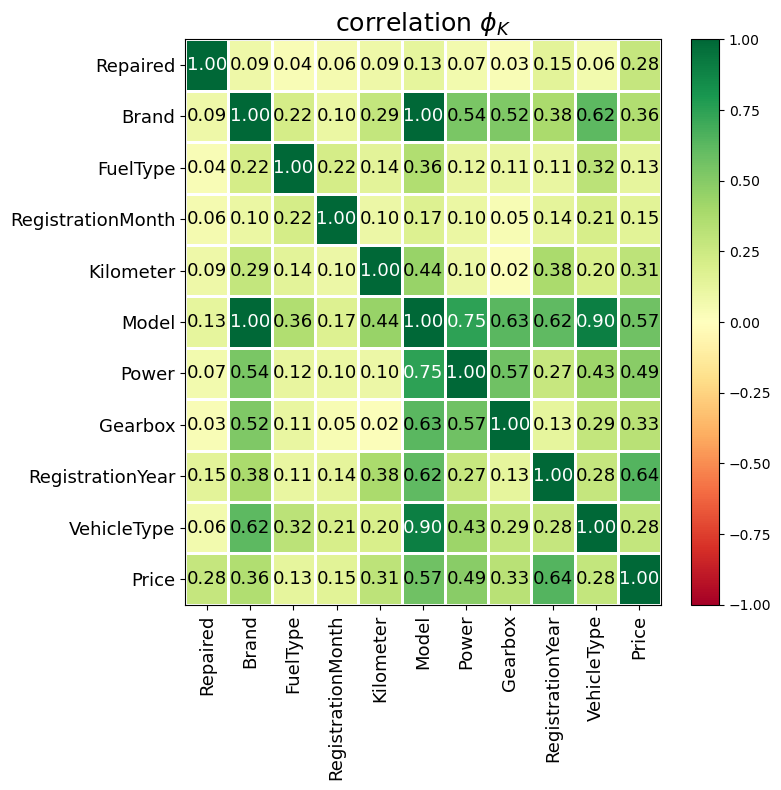

In [52]:
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"correlation $\phi_K$",
    fontsize_factor=1.3,
    figsize=(8,8)
)

По матрице корреляции видно, что целевой признак Price имеет достаточно сильную связь с признаками RegistrationYear - 0.64, Model - 0.57 и Power - 0.49.

Так же прослеживается сильная взаимосвязь, равная единице между признаками Model и Brand, поэтому при подготовке данных для машинного обучения столбец Brand будет лучше удалить.

Посмотрим еще на графики рассеивания числовых столбцов.

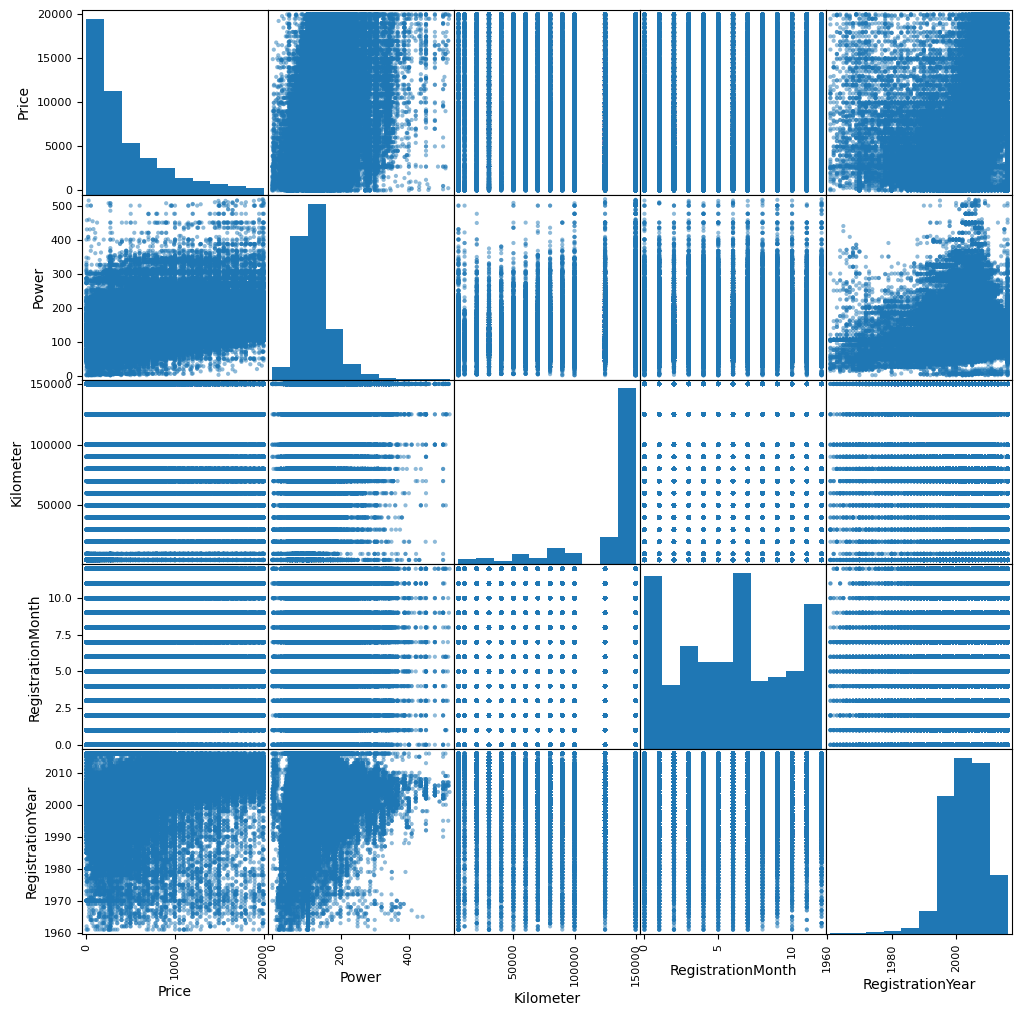

In [53]:
num_cols = ['Price', 'Power', 'Kilometer', 'RegistrationMonth', 'RegistrationYear']
pd.plotting.scatter_matrix(autos[num_cols], figsize=(12,12));

По графикам рассеивания числовых признаков четкой связи между целевым признаком и остальными не прослеживается кроме столбца Power - тут можно заметить некоторое увеличение цены с увеличением мощности двигателя.


Мы провели исследовательский анализ предоставленных данных, удалили аномальные значения в столбцах Power и RegistrationYear, заменили на медианные значения нули в столбцах Price и Power, проверили представленность признаков в категориальных столбцах и с помощью матрицы корреляции из библиотеки phik установили наличие связи между целевым признаком Price и признаками RegistrationYear - 0.64, Model - 0.57 и Power - 0.49.

Для дальнейшей работы будет необходимо отмасштабировать количественные столбцы, так как они содержат данные разного масштаба и провести кодирование категориальных столбцов, а так же удалить неинформативные для обучения модели столбцы с индексом и датами выгрузки анкет. Так же добавим в таблицу столбец SalesDuration (длительность продажи) - вычтем из столбца LastSeen столбец DateCreation.


## 4. Подготовка данных для МО.

### 4.1. Добавление столбца SalesDuration

В ходе подготовки данных для МО добавим столбец длительности продажи: вычтем из даты последней активности клиента (предположительно она близка к дате продажи машины) дату создания анкеты на сайте.

In [54]:
autos['SalesDuration'] = (autos['LastSeen']-autos['DateCreated']).dt.days
autos.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,PostalCode,LastSeen,SalesDuration
0,2016-03-24 11:52:17,480,other,1993,manual,105,golf,150000,0,petrol,volkswagen,no,2016-03-24,70435,2016-04-07 03:16:57,14
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,other,125000,5,petrol,audi,yes,2016-03-24,66954,2016-04-07 01:46:50,14
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,petrol,jeep,no,2016-03-14,90480,2016-04-05 12:47:46,22
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,91074,2016-03-17 17:40:17,0
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,petrol,skoda,no,2016-03-31,60437,2016-04-06 10:17:21,6


In [55]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 338838 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        338838 non-null  datetime64[ns]
 1   Price              338838 non-null  int64         
 2   VehicleType        338838 non-null  object        
 3   RegistrationYear   338838 non-null  int64         
 4   Gearbox            321193 non-null  object        
 5   Power              338838 non-null  int64         
 6   Model              338838 non-null  object        
 7   Kilometer          338838 non-null  int64         
 8   RegistrationMonth  338838 non-null  int64         
 9   FuelType           338838 non-null  object        
 10  Brand              338838 non-null  object        
 11  Repaired           338838 non-null  object        
 12  DateCreated        338838 non-null  datetime64[ns]
 13  PostalCode         338838 non-null  int64        

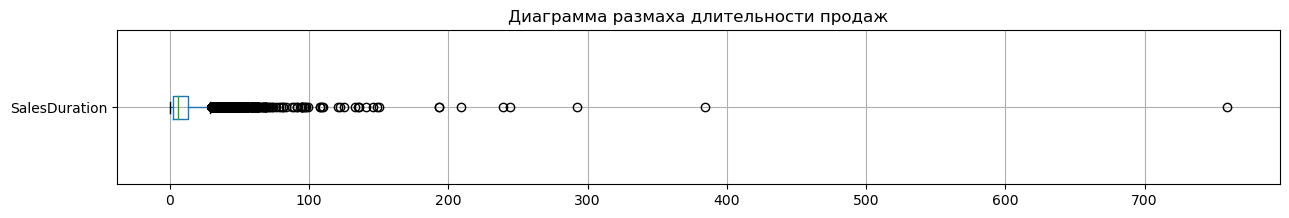

In [56]:
# Посмотрим на размах значений этого столбца

fig, ax = plt.subplots(figsize = (15,2))
ax = autos[['SalesDuration']].boxplot(vert=False, ax=ax)
ax.set_title('Диаграмма размаха длительности продаж');

Большинство значений сосредоточено в пределах от 0 до 20 дней примерно, но есть и выбросные значения больше 700 дней.

### 4.2. Удаление неинформативных столбцов

Подготовим список столбцов на удаление: уберем дату выгрузки данных, для модели эта дата будет не информативна. Вместо даты создания анкеты и даты последней активности у нас теперь есть столбец длительность продажи, индекс пока тоже уберем.

In [57]:
# Подготовим список столбцов на удаление

drop_cols = ['DateCrawled','DateCreated', 'PostalCode', 'LastSeen'] 

In [58]:
autos = autos.drop(drop_cols, axis = 1)
autos.shape

(338838, 12)

### 4.2. Разделение выборки

Разделим нашу таблицу на целевой и входящие признаки

In [59]:
X = autos.drop('Price', axis = 1)
y = autos['Price']
X.shape, y.shape

((338838, 11), (338838,))

In [60]:
# Зададим Random_state

RANDOM_STATE = 12

Разделим данные в нашей таблице на тренировочную и тестовую выборки в отношении (75:25)

In [61]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state = RANDOM_STATE)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((254128, 11), (84710, 11), (254128,), (84710,))

### 4.3. Подготовка данных.

Для дальнейшей работы с данными и обучения моделей необходимо провести подготовку данных: отмасштабировать количественные столбцы и провести кодировку категориальных колонок. Всю подготовительную работу мы будем проводить в пайплайнах.

In [62]:
X_train.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,SalesDuration
102823,other,2000,NaN,105,other,20000,0,other,bmw,no,0
299247,small,1996,manual,60,polo,150000,3,petrol,volkswagen,no,4
144032,other,1985,NaN,105,other,150000,0,other,porsche,no,12
314762,convertible,2000,auto,231,3er,150000,6,petrol,bmw,no,18
146084,other,2006,auto,14,other,5000,5,petrol,sonstige_autos,no,1


In [63]:
# Подготовим список количественных столбцов для кодирования:

num_cols = ['Power', 'Kilometer', 'RegistrationMonth', 'RegistrationYear', 'SalesDuration']

In [64]:
ohe_cols = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Repaired', 'Brand']

In [65]:
# Создадим Ohe-кодирование в пайплайн

ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
)

In [66]:
# Объединим предыдущий шаг и масштабирование числовых колонок в один процесс:

data_preprocessor = ColumnTransformer(
[
    ('ohe', ohe_pipe, ohe_cols),
    ('num', StandardScaler(), num_cols),
  
],
    remainder='passthrough'
)

In [67]:
# Тренируем data_preprocessor

data_preprocessor.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('ohe',
                                 Pipeline(steps=[('simpleImputer_ohe',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['VehicleType', 'Gearbox', 'Model', 'FuelType',
                                  'Repaired', 'Brand']),
                                ('num', StandardScaler(),
                                 ['Power', 'Kilometer', 'RegistrationMonth',
                                  'RegistrationYear', 'SalesDuration'])])

## 5. Подбор модели машинного обучения

Для выполнения этой задачи нам необходимо проверить две модели машинного обучения: посмотреть на качество работы, скорость их обучения и время предсказания. В качестве первой модели МО возьмем обычную модель линейной регрессии и дерево решений. Перебирать параметры будем через GridSearch. Во втором разделе проверим скорость и качество работы модели LightGBM.

### 5.1. Линейная регрессия и дерево решений.

In [68]:
# для расчета метрики RMSE будем использовать функцию make_scorer

def rmse (y_true, y_pred):
    y_true = np.array(y_true, dtype='float64')
    y_pred = np.array(y_pred, dtype='float64')
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

score = make_scorer(rmse, greater_is_better = False)

In [69]:
pipe_final = Pipeline(
[
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

In [70]:
pipe_final.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['VehicleType', 'Gearbox',
                                                   'Model', 'FuelType',
                                                   'Repaired', 'Brand']),
                                                 ('num', StandardScaler(),
                                                  ['Power', 'Kilometer',
                                                   'RegistrationMonth',
                                                   'RegistrationYear',
                                                   'SalesDuration'])])),
                ('models', LinearRegression())])

In [71]:
# Зададим словарь параметров для GridSearchCV

param_grid=[
    {'models':[LinearRegression()], 
    'preprocessor__num': [StandardScaler(), MinMaxScaler()] 
    },
   {
    'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)], 
    'models__max_depth': range(2,6), 
    'models__max_features': range(2,6),
    'preprocessor__num': [StandardScaler(), 'passthrough'] 
    } 
]

In [72]:
#Соберем и запустим поиск лучшей модели

grid_search=GridSearchCV(
pipe_final,
param_grid,
n_jobs=-1,
cv=5,
scoring = score
)

In [73]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['VehicleType',
                                                                          'Gearbox',
                                                                          'Model',
                                                                          'FuelType',
                                                                          'Repaired',
                                                                          'Brand']),
                                                                        ('...
             n_jobs=-1,
             param_grid=[{'models': [LinearRegression()],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler()]},
                         {'models': [DecisionTreeRegressor(random_state=12)],
                          'models__max_depth': range(2, 6),
                          'models__max_features': range(2, 6),
                          'preprocessor__num': [StandardScaler(),
                                                'passthrough']}],
             scoring=make_scorer(rmse, greater_is_better=False, response_method='predict'))

In [74]:
print('Лучшая модель и её параметры:\n\n', grid_search.best_estimator_)
print ('Метрика лучшей модели на при кросс-валидации:', (-round(grid_search.best_score_)))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['VehicleType', 'Gearbox',
                                                   'Model', 'FuelType',
                                                   'Repaired', 'Brand']),
                 

In [75]:
result = pd.DataFrame(grid_search.cv_results_)
result[
    ['mean_fit_time', 'mean_score_time','rank_test_score', 'param_models', 'mean_test_score','params']
].sort_values('rank_test_score').head(10) 

,mean_fit_time,mean_score_time,rank_test_score,param_models,mean_test_score,params
0,62.824450,3.132140,1,LinearRegression(),-2684.155624,"{'models': LinearRegression(), 'preprocessor__..."
1,63.657998,3.698185,2,LinearRegression(),-2684.155624,"{'models': LinearRegression(), 'preprocessor__..."
32,14.238569,1.949931,3,DecisionTreeRegressor(random_state=12),-3971.145887,{'models': DecisionTreeRegressor(random_state=...
33,10.997877,0.882639,3,DecisionTreeRegressor(random_state=12),-3971.145887,{'models': DecisionTreeRegressor(random_state=...
31,12.670109,2.691910,5,DecisionTreeRegressor(random_state=12),-4061.250420,{'models': DecisionTreeRegressor(random_state=...
30,10.573745,1.836992,5,DecisionTreeRegressor(random_state=12),-4061.250420,{'models': DecisionTreeRegressor(random_state=...
22,12.390159,1.776040,7,DecisionTreeRegressor(random_state=12),-4400.526475,{'models': DecisionTreeRegressor(random_state=...
23,12.812577,2.672733,7,DecisionTreeRegressor(random_state=12),-4400.526475,{'models': DecisionTreeRegressor(random_state=...
29,12.941862,2.486455,9,DecisionTreeRegressor(random_state=12),-4415.428376,{'models': DecisionTreeRegressor(random_state=...
28,14.391263,2.924083,9,DecisionTreeRegressor(random_state=12),-4415.428376,{'models': DecisionTreeRegressor(random_state=...


Лучшей моделью оказалась модель линейной регрессии с RMSE при кросс-валидации 2684

Посмотрим на время обучения и работы лучшей модели.

In [78]:
start = time.time()
model_1 = grid_search.best_estimator_
model_1.fit(X_train, y_train)
end = time.time() 
print('Время обучения модели составило', round(end-start,2), 'секунд')

Время обучения модели составило 13.59 секунд


In [80]:
start = time.time()
predictions = model_1.predict(X_train)
end = time.time()
print('Время предсказания модели составило', round(end-start,2), 'секунд')


Время предсказания модели составило 1.49 секунд


Из простых моделей лучшей оказалась модель линейной регрессии с результатом RMSE при кросс-валидации 2684. Время обучения модели около 14 секунд, время предсказания на тренировочной выборке - 1,4 с.

### 5.2. Модель LightGBM

Посмотрим на работу модели LightGBM. Кодировщики категориальных признаков для этой модели нам не понадобятся, но нужно поменять тип данных у категориальных столбцов и заполнить пропуски в столбце GearBox самым частым значением

In [81]:
# Поменяем тип столбцов на категориальный в выборке X_train

X_train[ohe_cols] = X_train[ohe_cols].astype('category')
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 254128 entries, 102823 to 245920
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   VehicleType        254128 non-null  category
 1   RegistrationYear   254128 non-null  int64   
 2   Gearbox            240842 non-null  category
 3   Power              254128 non-null  int64   
 4   Model              254128 non-null  category
 5   Kilometer          254128 non-null  int64   
 6   RegistrationMonth  254128 non-null  int64   
 7   FuelType           254128 non-null  category
 8   Brand              254128 non-null  category
 9   Repaired           254128 non-null  category
 10  SalesDuration      254128 non-null  int64   
dtypes: category(6), int64(5)
memory usage: 13.3 MB


In [82]:
# Заполним пропуски модой

most_frequent_gearbox = X_train['Gearbox'].mode()[0]
X_train['Gearbox'] = X_train['Gearbox'].fillna(most_frequent_gearbox)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 254128 entries, 102823 to 245920
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   VehicleType        254128 non-null  category
 1   RegistrationYear   254128 non-null  int64   
 2   Gearbox            254128 non-null  category
 3   Power              254128 non-null  int64   
 4   Model              254128 non-null  category
 5   Kilometer          254128 non-null  int64   
 6   RegistrationMonth  254128 non-null  int64   
 7   FuelType           254128 non-null  category
 8   Brand              254128 non-null  category
 9   Repaired           254128 non-null  category
 10  SalesDuration      254128 non-null  int64   
dtypes: category(6), int64(5)
memory usage: 13.3 MB


In [83]:
parametrs = {'n_estimators': [10, 15, 20, 50, 70,90]
    
}
model =LGBMRegressor()

In [84]:
grid_lgbm = GridSearchCV(
  model,
  parametrs,
  scoring=score,
  n_jobs=-1,
  cv=5
) 

In [85]:
grid_lgbm.fit(X_train, y_train)

C:\ProgramData\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\ProgramData\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023233 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 680
[LightGBM] [Info] Number of data points in the train set: 254128, number of used features: 11
[LightGBM] [Info] Start training from score 4546.367760


GridSearchCV(cv=5, estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'n_estimators': [10, 15, 20, 50, 70, 90]},
             scoring=make_scorer(rmse, greater_is_better=False, response_method='predict'))

In [86]:
print('Лучшая модель и её параметры:\n\n', grid_lgbm.best_estimator_)
print ('Метрика лучшей модели при кросс-валидации:', (-round(grid_lgbm.best_score_)))

Лучшая модель и её параметры:

 LGBMRegressor(n_estimators=90)
Метрика лучшей модели при кросс-валидации: 1678


In [87]:
# Выведем таблицу с лучшими результатами

result = pd.DataFrame(grid_lgbm.cv_results_)
result[
    ['mean_fit_time', 'mean_score_time','rank_test_score', 'mean_test_score','params']
].sort_values('rank_test_score').head(10)

,mean_fit_time,mean_score_time,rank_test_score,mean_test_score,params
5,18.780071,0.434320,1,-1677.819688,{'n_estimators': 90}
4,17.256545,0.343221,2,-1698.345743,{'n_estimators': 70}
3,10.071037,0.279832,3,-1729.779171,{'n_estimators': 50}
2,2.001696,0.024530,4,-1995.284106,{'n_estimators': 20}
1,1.768600,0.040713,5,-2190.686143,{'n_estimators': 15}
0,1.260227,0.031976,6,-2546.630024,{'n_estimators': 10}


Проверим скорость работы лучшей модели.

In [88]:
start = time.time()
model_2 = grid_lgbm.best_estimator_
model_2.fit(X_train, y_train)
end = time.time() 
print('Время обучения модели составило', round(end-start,2), 'секунд')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017351 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 680
[LightGBM] [Info] Number of data points in the train set: 254128, number of used features: 11
[LightGBM] [Info] Start training from score 4546.367760
Время обучения модели составило 1.74 секунд


In [89]:
start = time.time()
predictions = model_2.predict(X_train)
end = time.time()
print('Время предсказания модели составило', round(end-start,2), 'секунд')

Время предсказания модели составило 0.77 секунд


Модель LightGBM оказалась точнее и быстрее модели линейной регрессии. Посмотрим на результаты лучшей модели на тестовой выборке.

In [90]:
X_test[ohe_cols]=X_test[ohe_cols].astype('category')
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 84710 entries, 324035 to 9373
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   VehicleType        84710 non-null  category
 1   RegistrationYear   84710 non-null  int64   
 2   Gearbox            80351 non-null  category
 3   Power              84710 non-null  int64   
 4   Model              84710 non-null  category
 5   Kilometer          84710 non-null  int64   
 6   RegistrationMonth  84710 non-null  int64   
 7   FuelType           84710 non-null  category
 8   Brand              84710 non-null  category
 9   Repaired           84710 non-null  category
 10  SalesDuration      84710 non-null  int64   
dtypes: category(6), int64(5)
memory usage: 4.5 MB


In [91]:
# Заполним пропуски в столбце Gearbox

most_frequent_gearbox = X_test['Gearbox'].mode()[0]
X_test['Gearbox'] = X_test['Gearbox'].fillna(most_frequent_gearbox)
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 84710 entries, 324035 to 9373
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   VehicleType        84710 non-null  category
 1   RegistrationYear   84710 non-null  int64   
 2   Gearbox            84710 non-null  category
 3   Power              84710 non-null  int64   
 4   Model              84710 non-null  category
 5   Kilometer          84710 non-null  int64   
 6   RegistrationMonth  84710 non-null  int64   
 7   FuelType           84710 non-null  category
 8   Brand              84710 non-null  category
 9   Repaired           84710 non-null  category
 10  SalesDuration      84710 non-null  int64   
dtypes: category(6), int64(5)
memory usage: 4.5 MB


In [92]:

preds = model_2.predict(X_test)
print('RMSE лучшей модели на тестовой выборке', 
          round(mean_squared_error(y_test, preds, squared=False)))

RMSE лучшей модели на тестовой выборке 1671


C:\Users\Роман Полицинский\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## 6. Вывод.

В ходе проведенного исследования мы провели предобработку данных: проверили данные на дубликаты, скрытые и яные, обработали пропуски и нулевые значения, избавились от аномальных значений в столбцах Power и RegistrationYear. Затем данные были исследованы на предмет связей - выявлена зависимость между целевым признаком Price и признаками RegistrationYear, Model и Power.
В процессе подготовки данных для MO выборка была разделена на тренировочную и тестовую в размере 75:25, неинформативные для модели столбы удалены, категориальные столбцы закодированы, а числовые отмасштабированы.

Нами было обучено две простых моделей линейной регрессии (LinearRegression, Ridge), DecisionTreeRegressor, а так же модель градиентного бустинга LightGBM.

Из простых моделей наиболее точной оказалась LinearRegression c метрикой RMSE на тренировочной выборке 2684. 

Модель LightGBMRegressor показала на тренировочной выборке более высокую скорость обучения и предсказания по сравнению с линейной регрессией и при этом большую точность (RMSE лучшей модели при кросс-валидации - 1678).  


Таким образом лучшей моделью в ходе проведенной работы стала модель LightGBM с 90 решающими деревьями. Метрика RMSE лучшей модели на тестовых данных составила 1671. 